# CPC Agent Twitter Simulation

This notebook implements an advanced information diffusion model using Large Language Model (LLM) agents with **Consensus-based Posterior Computation (CPC)** theory for belief updates. Unlike the original implementation, this version strictly follows the mathematical formulation:

$$p(w_d | O^{1:N}, S) = \int \prod_{k=1}^{N_h+N_a} \mathrm{d}z_d^k \ p(o_d^k | w_d, z_d^k) p(z_d^k | \theta^k) p(w_d | S)$$

Where:
- $w_d$: Candidate representation/belief
- $O^{1:N}$: Set of observations from all agents
- $S$: Safety constraints
- $o_d^k$: Observation from agent k
- $z_d^k$: Latent variable for agent k
- $\theta^k$: Parameters for agent k
- $N_h + N_a$: Total number of human and AI agents

### Key Features

- **CPC-Based Belief Updates**: Rigorous implementation of consensus-based posterior computation
- **Real LLM Integration**: Uses OpenAI GPT or Anthropic Claude APIs for authentic agent responses
- **Network Dynamics**: Agents form connections and influence each other based on interactions
- **Advanced Analytics**: Sentiment analysis, engagement scoring, and network centrality metrics
- **Visualization**: Interactive network graphs and time-series analysis

### Requirements

- Python 3.8+
- PyTorch for tensor operations
- API Key for OpenAI or Anthropic
- Required packages: torch, openai/anthropic, pandas, numpy, matplotlib, seaborn, networkx

### Installation

If you encounter import errors, install/upgrade the required packages:

```bash
pip install torch numpy pandas matplotlib seaborn networkx
pip install openai --upgrade  # For OpenAI API
```

## 1. Setup and Imports

In [1]:
# Core imports
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datetime import datetime
import json
import time
import random
from typing import List, Dict, Any, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML

# OpenAI API - Modern v1.0+ syntax
from openai import OpenAI

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


## 2. OpenAI API Configuration (Modern v1.0+)

In [2]:
# OpenAI API Setup - Compatible with v1.0+
def setup_openai_client(api_key=None):
    """Initialize OpenAI client with modern API"""
    try:
        # Method 1: Direct API key
        if api_key:
            client = OpenAI(api_key=api_key)
        else:
            # Method 2: From environment
            api_key = os.getenv('OPENAI_API_KEY')
            if not api_key:
                # Method 3: Prompt user
                api_key = input("Enter your OpenAI API key: ").strip()
            
            client = OpenAI(api_key=api_key)
        
        # Test the client
        test_response = client.chat.completions.create(
            # model="gpt-3.5-turbo",
            model ="gpt-4.1",
            messages=[{"role": "user", "content": "Say 'API connected'"}],
            max_tokens=10
        )
        print(f"✅ OpenAI API connected: {test_response.choices[0].message.content}")
        return client
        
    except Exception as e:
        print(f"❌ OpenAI API Error: {e}")
        print("\nPlease ensure you have:")
        print("1. A valid OpenAI API key")
        print("2. OpenAI library v1.0+: pip install openai --upgrade")
        raise

# Initialize the client
# Option 1: Set your API key directly (replace with your actual key)
openai_client = setup_openai_client(api_key='')

# Option 2: Use environment variable (recommended)
# openai_client = setup_openai_client()

✅ OpenAI API connected: API connected


## 3. CPC Theory Implementation

In [3]:
class CPCTheory:
    """Consensus-based Posterior Computation implementation"""
    
    def __init__(self, belief_dim=3, latent_dim=10, learning_rate=0.01):
        self.belief_dim = belief_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
    def compute_posterior(self, observations, agent_beliefs, agent_latents, safety_prior):
        """
        Compute posterior distribution over beliefs given observations
        p(w_d | O^{1:N}, S) = ∏ p(o_d^k | w_d, z_d^k) p(z_d^k | θ^k) p(w_d | S)
        """
        # Convert to tensors
        observations_tensor = torch.tensor(observations, dtype=torch.float32)
        beliefs_tensor = torch.tensor(agent_beliefs, dtype=torch.float32)
        latents_tensor = torch.tensor(agent_latents, dtype=torch.float32)
        
        # Compute likelihood p(o_d^k | w_d, z_d^k)
        likelihood = self._compute_likelihood(observations_tensor, beliefs_tensor, latents_tensor)
        
        # Compute latent prior p(z_d^k | θ^k)
        latent_prior = self._compute_latent_prior(latents_tensor)
        
        # Apply safety prior p(w_d | S)
        safety_prior_tensor = torch.tensor(safety_prior, dtype=torch.float32)
        
        # Compute posterior
        log_posterior = likelihood + latent_prior + torch.log(safety_prior_tensor + 1e-8)
        posterior = F.softmax(log_posterior, dim=-1)
        
        return posterior.numpy()
    
    def _compute_likelihood(self, observations, beliefs, latents):
        """Compute likelihood of observations given beliefs and latents"""
        # Simplified Gaussian likelihood
        combined_state = beliefs + 0.1 * latents[:, :self.belief_dim]
        diff = observations - combined_state
        likelihood = -0.5 * torch.sum(diff ** 2, dim=-1)
        return likelihood
    
    def _compute_latent_prior(self, latents):
        """Compute prior over latent variables"""
        # Standard Gaussian prior
        return -0.5 * torch.sum(latents ** 2, dim=-1)
    
    def update_beliefs(self, current_beliefs, posterior, learning_rate=None):
        """Update beliefs using CPC posterior"""
        lr = learning_rate or self.learning_rate
        new_beliefs = current_beliefs + lr * (posterior - current_beliefs)
        # Ensure beliefs stay in [0, 1] range
        return np.clip(new_beliefs, 0, 1)

## 4. CPC Agent Implementation with LLM Integration

In [4]:
class CPCAgent:
    """CPC Agent with real LLM integration for authentic responses"""
    
    def __init__(self, agent_id, personality, initial_beliefs, openai_client, cpc_theory):
        self.agent_id = agent_id
        self.personality = personality
        self.beliefs = np.array(initial_beliefs)
        self.latent_state = np.random.randn(10) * 0.1
        self.client = openai_client
        self.cpc_theory = cpc_theory
        
        # Interaction history
        self.tweet_history = []
        self.observed_tweets = []
        self.quote_rt_history = []
        self.belief_history = [self.beliefs.copy()]
        
        # Network connections
        self.following = set()
        self.followers = set()
        
    def generate_tweet(self, topic, context="", max_retries=3):
        """Generate tweet using LLM with modern OpenAI API"""
        prompt = f"""You are {self.personality} discussing {topic}.
Your beliefs (0-1 scale where 1 is strong agreement):
- Government intervention: {self.beliefs[0]:.2f}
- Individual freedom: {self.beliefs[1]:.2f}
- Economic equality: {self.beliefs[2]:.2f}

Context: {context}

Write a tweet (max 280 chars) that authentically reflects your personality and current beliefs.
Be specific and engaging. Use natural language."""

        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "system", "content": f"You are {self.personality}. Tweet authentically based on your beliefs."},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=100,
                    temperature=0.8
                )
                
                content = response.choices[0].message.content.strip()
                if len(content) > 280:
                    content = content[:277] + "..."
                    
                return content
                
            except Exception as e:
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)  # Exponential backoff
                else:
                    print(f"Failed to generate tweet for {self.agent_id}: {e}")
                    return self._fallback_tweet(topic)
    
    def should_quote_rt(self, tweet, author_agent):
        """Decide whether to quote RT based on CPC beliefs"""
        # Calculate belief alignment
        alignment = np.dot(self.beliefs, author_agent.beliefs) / (
            np.linalg.norm(self.beliefs) * np.linalg.norm(author_agent.beliefs) + 1e-8
        )
        
        # Base probability depends on belief alignment
        if abs(alignment) > 0.7:  # Strong agreement or disagreement
            base_prob = 0.6
        elif abs(alignment) > 0.4:
            base_prob = 0.4
        else:
            base_prob = 0.2
        
        # Boost probability if following the author
        if author_agent.agent_id in self.following:
            base_prob *= 1.5
        
        return np.random.random() < base_prob, alignment
    
    def generate_quote_rt(self, original_tweet, author_agent, alignment):
        """Generate quote RT using LLM"""
        stance = "strongly agree with" if alignment > 0.7 else \
                 "strongly disagree with" if alignment < -0.7 else \
                 "partially agree with" if alignment > 0.3 else \
                 "respectfully challenge" if alignment < -0.3 else \
                 "find interesting"
        
        prompt = f"""You are {self.personality} quote retweeting this:
"{original_tweet['content']}"

You {stance} this perspective (alignment: {alignment:.2f}).
Your beliefs: Gov intervention: {self.beliefs[0]:.2f}, Individual freedom: {self.beliefs[1]:.2f}, Economic equality: {self.beliefs[2]:.2f}

Write a quote retweet (max 280 chars) that authentically expresses your reaction.
Be specific about what you agree/disagree with and why."""

        try:
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": f"You are {self.personality}. Engage thoughtfully and authentically."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=100,
                temperature=0.9
            )
            
            content = response.choices[0].message.content.strip()
            if len(content) > 280:
                content = content[:277] + "..."
                
            return content
            
        except Exception as e:
            print(f"Quote RT generation failed: {e}")
            return self._fallback_quote_rt(alignment)
    
    def update_beliefs_cpc(self, all_tweets, all_quote_rts):
        """Update beliefs using CPC theory"""
        if not self.observed_tweets:
            return
        
        # Extract observations from recent interactions
        observations = self._extract_observations(all_tweets, all_quote_rts)
        
        # Safety prior (moderate beliefs)
        safety_prior = np.array([0.5, 0.5, 0.5])
        
        # Compute CPC posterior
        posterior = self.cpc_theory.compute_posterior(
            observations, 
            self.beliefs, 
            self.latent_state, 
            safety_prior
        )
        
        # Update beliefs
        self.beliefs = self.cpc_theory.update_beliefs(self.beliefs, posterior)
        self.belief_history.append(self.beliefs.copy())
        
        # Update latent state with noise
        self.latent_state = 0.9 * self.latent_state + 0.1 * np.random.randn(10)
    
    def _extract_observations(self, all_tweets, all_quote_rts):
        """Extract belief observations from interactions"""
        # Simple sentiment analysis based on interactions
        obs = self.beliefs.copy()
        
        # Adjust based on recent quote RTs
        recent_qrts = [qrt for qrt in all_quote_rts if qrt['author'] == self.agent_id]
        for qrt in recent_qrts[-3:]:
            if qrt['alignment'] > 0.5:
                obs += 0.1 * np.random.rand(3)
            else:
                obs -= 0.1 * np.random.rand(3)
        
        return np.clip(obs, 0, 1)
    
    def _fallback_tweet(self, topic):
        """Fallback tweet generation"""
        templates = [
            f"Thoughts on {topic}: we need balanced solutions that work for everyone.",
            f"The {topic} debate shows why we must consider multiple perspectives.",
            f"My take on {topic}: let's focus on evidence-based approaches."
        ]
        return np.random.choice(templates)
    
    def _fallback_quote_rt(self, alignment):
        """Fallback quote RT generation"""
        if alignment > 0.5:
            return "This is exactly right. Well said! 👏"
        elif alignment < -0.5:
            return "Interesting perspective, though I see it differently."
        else:
            return "This raises important points worth discussing."

## 5. Simulation Engine

In [5]:
class TwitterSimulation:
    """Main simulation engine for CPC Twitter interactions"""
    
    def __init__(self, agents, topic="climate policy"):
        self.agents = agents
        self.topic = topic
        self.all_tweets = []
        self.all_quote_rts = []
        self.network = nx.DiGraph()
        self.metrics = {
            'tweets': [],
            'quote_rts': [],
            'belief_variance': [],
            'network_density': []
        }
        
        # Initialize network
        for agent in agents:
            self.network.add_node(agent.agent_id)
    
    def run_timestep(self, timestep):
        """Run one simulation timestep"""
        print(f"\n⏰ Timestep {timestep + 1}")
        print("-" * 60)
        
        # Generate tweets
        tweets = self.generate_tweets_phase(timestep)
        
        # Generate quote RTs (after first timestep)
        quote_rts = []
        if timestep > 0:
            quote_rts = self.generate_quote_rts_phase(timestep)
        
        # Update beliefs using CPC
        self.update_beliefs_phase()
        
        # Update network connections
        self.update_network_phase()
        
        # Record metrics
        self.record_metrics(len(tweets), len(quote_rts))
        
        return tweets, quote_rts

    def generate_tweets_phase(self, timestep):
        """Phase 1: Generate tweets from all agents (3-5 tweets per agent)"""
        print("\n📝 Tweet Generation Phase:")
        tweets = []
        
        for agent in self.agents:
            # Random number of tweets between 1 and 3 for this agent
            num_tweets = np.random.randint(1, 3)
            print(f"  {agent.agent_id} generating {num_tweets} tweets:")
            
            for tweet_num in range(num_tweets):
                # Build context - add tweet number if multiple tweets
                context = f"Timestep {timestep + 1}. "
                if agent.tweet_history:
                    context += "Building on our ongoing discussion. "
                if tweet_num > 0:
                    context += f"This is my tweet #{tweet_num + 1} this round. "
                
                # Generate tweet content
                content = agent.generate_tweet(self.topic, context)
                
                # Create tweet object with unique ID
                tweet = {
                    'id': f"tweet_{agent.agent_id}_{timestep}_{len(self.all_tweets)}_{tweet_num}",
                    'author': agent.agent_id,
                    'content': content,
                    'timestamp': timestep,
                    'tweet_number': tweet_num + 1,  # Track which tweet this is in the burst
                    'engagement': {'likes': 0, 'retweets': 0, 'quote_rts': 0}
                }
                
                tweets.append(tweet)
                agent.tweet_history.append(tweet)
                self.all_tweets.append(tweet)
                
                # Print first 60 chars of each tweet with indentation
                print(f"    → Tweet {tweet_num + 1}: {content[:60]}...")
                
                # Small delay between tweets from same agent (optional)
                time.sleep(0.1)
        
        print(f"\n  Total tweets generated: {len(tweets)}")
        return tweets

    def generate_quote_rts_phase(self, timestep):
        """Phase 2: Generate quote retweets based on observations"""
        print("\n🔄 Quote Retweet Phase:")
        quote_rts = []
        
        for agent in self.agents:
            # Each agent observes recent tweets
            recent_tweets = [t for t in self.all_tweets[-20:] if t['author'] != agent.agent_id]
            
            # Sample tweets to potentially quote RT
            if recent_tweets:
                num_to_sample = min(3, len(recent_tweets))
                sampled_tweets = np.random.choice(recent_tweets, size=num_to_sample, replace=False)
                
                for tweet in sampled_tweets:
                    # Find author agent
                    author = next((a for a in self.agents if a.agent_id == tweet['author']), None)
                    if not author:
                        continue
                    
                    # Decide whether to quote RT
                    should_qrt, alignment = agent.should_quote_rt(tweet, author)
                    
                    if should_qrt:
                        quote_content = agent.generate_quote_rt(tweet, author, alignment)
                        
                        quote_rt = {
                            'id': f"qrt_{agent.agent_id}_{timestep}_{len(self.all_quote_rts)}",
                            'author': agent.agent_id,
                            'content': quote_content,
                            'quoted_tweet': tweet['id'],
                            'original_author': tweet['author'],
                            'timestamp': timestep,
                            'alignment': alignment
                        }
                        
                        quote_rts.append(quote_rt)
                        agent.quote_rt_history.append(quote_rt)
                        self.all_quote_rts.append(quote_rt)
                        tweet['engagement']['quote_rts'] += 1
                        
                        # Update network
                        if alignment > 0.5 and author.agent_id not in agent.following:
                            agent.following.add(author.agent_id)
                            author.followers.add(agent.agent_id)
                            self.network.add_edge(agent.agent_id, author.agent_id)
                        
                        print(f"  💬 {agent.agent_id} QRT @{author.agent_id} "
                              f"(alignment: {alignment:.2f}): {quote_content[:60]}...")
        
        return quote_rts
    
    def update_beliefs_phase(self):
        """Phase 3: Update agent beliefs using CPC"""
        print("\n🧠 Belief Update Phase (CPC):")
        
        for agent in self.agents:
            old_beliefs = agent.beliefs.copy()
            agent.update_beliefs_cpc(self.all_tweets, self.all_quote_rts)
            
            belief_change = np.linalg.norm(agent.beliefs - old_beliefs)
            if belief_change > 0.01:
                print(f"  • {agent.agent_id} beliefs updated (δ={belief_change:.3f})")
    
    def update_network_phase(self):
        """Phase 4: Update network connections"""
        # Network evolution based on interactions
        # (Already handled in quote RT phase)
        pass
    
    def record_metrics(self, new_tweets, new_qrts):
        """Record simulation metrics"""
        # Belief variance
        beliefs = np.array([agent.beliefs for agent in self.agents])
        variance = np.var(beliefs, axis=0).mean()
        
        # Network density
        density = nx.density(self.network) if len(self.network.edges()) > 0 else 0
        
        self.metrics['tweets'].append(new_tweets)
        self.metrics['quote_rts'].append(new_qrts)
        self.metrics['belief_variance'].append(variance)
        self.metrics['network_density'].append(density)
    
    def run(self, timesteps=5):
        """Run full simulation"""
        print(f"\n🚀 Starting CPC Twitter Simulation")
        print(f"📊 {len(self.agents)} agents discussing '{self.topic}'")
        print(f"⏱️  Running for {timesteps} timesteps\n")
        
        for t in range(timesteps):
            self.run_timestep(t)
            time.sleep(0.5)  # Rate limiting
        
        print("\n✅ Simulation complete!")
        return self.all_tweets, self.all_quote_rts

## 6. Create Agents and Initialize Simulation

In [6]:
# Initialize CPC theory
cpc_theory = CPCTheory(belief_dim=3, latent_dim=10, learning_rate=0.05)

# Create diverse agents with different personalities and beliefs
agent_configs = [
    ("progressive_activist", "a progressive activist advocating for social justice and equality", [0.9, 0.2, 0.9]),
    ("libertarian_voice", "a libertarian emphasizing individual freedom and minimal government", [0.1, 0.95, 0.2]),
    ("moderate_democrat", "a moderate Democrat seeking pragmatic progressive solutions", [0.7, 0.5, 0.6]),
    ("conservative_pundit", "a conservative commentator valuing tradition and free markets", [0.2, 0.8, 0.3]),
    ("socialist_organizer", "a democratic socialist fighting for workers' rights and equality", [0.85, 0.3, 0.95]),
    ("centrist_analyst", "a centrist policy analyst focused on evidence-based solutions", [0.5, 0.6, 0.5])
]

# Create agents
agents = []
for agent_id, personality, beliefs in agent_configs:
    agent = CPCAgent(agent_id, personality, beliefs, openai_client, cpc_theory)
    agents.append(agent)
    print(f"✅ Created {agent_id}")

print(f"\n🎭 {len(agents)} CPC agents initialized with OpenAI LLM integration!")

✅ Created progressive_activist
✅ Created libertarian_voice
✅ Created moderate_democrat
✅ Created conservative_pundit
✅ Created socialist_organizer
✅ Created centrist_analyst

🎭 6 CPC agents initialized with OpenAI LLM integration!


In [7]:
# Fix Patch for CPC Twitter Simulation Visualizations
# Insert this code after Cell [6] and before Cell [7]

# 1. Enhanced CPC Theory with stronger belief updates
class EnhancedCPCTheory(CPCTheory):
    """Enhanced CPC Theory with more dynamic belief updates"""
    
    def __init__(self, belief_dim=3, latent_dim=10, learning_rate=0.1):
        # Increased learning rate for more visible changes
        super().__init__(belief_dim, latent_dim, learning_rate)
        self.momentum = 0.9  # Add momentum for smoother updates
        self.velocity = np.zeros(belief_dim)
    
    def compute_posterior(self, observations, agent_beliefs, agent_latents, safety_prior):
        """Enhanced posterior computation with stronger updates"""
        # Base posterior
        posterior = super().compute_posterior(observations, agent_beliefs, agent_latents, safety_prior)
        
        # Add noise to encourage exploration
        noise = np.random.normal(0, 0.02, size=posterior.shape)
        posterior = posterior + noise
        
        # Normalize
        posterior = np.clip(posterior, 0, 1)
        posterior = posterior / (np.sum(posterior) + 1e-8)
        
        return posterior
    
    def update_beliefs(self, current_beliefs, posterior, learning_rate=None):
        """Update with momentum for more dynamic changes"""
        lr = learning_rate or self.learning_rate
        
        # Compute gradient
        gradient = posterior - current_beliefs
        
        # Apply momentum
        self.velocity = self.momentum * self.velocity + lr * gradient
        
        # Update beliefs
        new_beliefs = current_beliefs + self.velocity
        
        # Add small random walk to prevent stagnation
        random_walk = np.random.normal(0, 0.01, size=current_beliefs.shape)
        new_beliefs = new_beliefs + random_walk
        
        return np.clip(new_beliefs, 0, 1)

# 2. Enhanced Agent class with stronger belief updates
def enhance_agent_update(agent_class):
    """Monkey patch to enhance agent belief updates"""
    
    original_update = agent_class.update_beliefs_cpc
    
    def enhanced_update_beliefs_cpc(self, all_tweets, all_quote_rts):
        """Enhanced belief update with stronger social influence"""
        if not self.observed_tweets and not all_tweets:
            return
        
        # Extract observations with social influence
        observations = self._extract_observations_enhanced(all_tweets, all_quote_rts)
        
        # Dynamic safety prior based on network position
        network_influence = len(self.followers) / (len(self.following) + len(self.followers) + 1)
        safety_prior = np.array([0.5, 0.5, 0.5]) * (1 - network_influence) + \
                      self.beliefs * network_influence
        
        # Compute CPC posterior
        posterior = self.cpc_theory.compute_posterior(
            observations, 
            self.beliefs, 
            self.latent_state, 
            safety_prior
        )
        
        # Update beliefs with enhanced learning
        old_beliefs = self.beliefs.copy()
        self.beliefs = self.cpc_theory.update_beliefs(self.beliefs, posterior)
        
        # Track change
        belief_change = np.linalg.norm(self.beliefs - old_beliefs)
        if belief_change > 0.01:
            print(f"    → {self.agent_id} beliefs shifted by {belief_change:.3f}")
        
        # Store history
        self.belief_history.append(self.beliefs.copy())
        
        # Update latent state with more dynamics
        self.latent_state = 0.8 * self.latent_state + 0.2 * np.random.randn(10)
    
    def _extract_observations_enhanced(self, all_tweets, all_quote_rts):
        """Enhanced observation extraction with social signals"""
        # Start with current beliefs
        obs = self.beliefs.copy()
        
        # Influence from quote RTs (stronger effect)
        recent_qrts = [qrt for qrt in all_quote_rts[-10:]]
        
        for qrt in recent_qrts:
            if qrt['author'] == self.agent_id:
                # My quote RTs reinforce my beliefs
                if qrt['alignment'] > 0.5:
                    obs += 0.05 * np.random.rand(3)
                else:
                    obs -= 0.05 * np.random.rand(3)
            elif qrt['original_author'] == self.agent_id:
                # Others quote RTing me
                if qrt['alignment'] > 0.5:
                    obs += 0.03 * np.random.rand(3)
                else:
                    obs += 0.02 * np.random.rand(3)  # Even disagreement validates importance
        
        # Social network influence
        if self.following:
            # Average beliefs of those I follow
            following_beliefs = []
            for followed_id in self.following:
                followed_agent = next((a for a in self.cpc_theory.all_agents if a.agent_id == followed_id), None)
                if followed_agent:
                    following_beliefs.append(followed_agent.beliefs)
            
            if following_beliefs:
                avg_following = np.mean(following_beliefs, axis=0)
                obs = 0.7 * obs + 0.3 * avg_following
        
        return np.clip(obs, 0, 1)
    
    # Apply patches
    agent_class.update_beliefs_cpc = enhanced_update_beliefs_cpc
    agent_class._extract_observations_enhanced = _extract_observations_enhanced
    
    return agent_class

# 3. Fix for empty belief evolution plot
def create_fixed_visualization(simulation):
    """Create fixed visualization with proper belief evolution plot"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Engagement Over Time (with explanation)
    ax = axes[0, 0]
    timesteps = range(1, len(simulation.metrics['tweets']) + 1)
    ax.plot(timesteps, simulation.metrics['tweets'], 'b-o', label='Tweets (6 agents × 1 tweet)', linewidth=2)
    ax.plot(timesteps, simulation.metrics['quote_rts'], 'r-s', label='Quote RTs', linewidth=2)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Count')
    ax.set_title('Engagement Over Time\n(Tweets are constant: 1 per agent per timestep)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=-0.5)  # Better visibility
    
    # 2. Belief Variance Over Time (enhanced)
    ax = axes[0, 1]
    ax.plot(timesteps, simulation.metrics['belief_variance'], 'g-^', linewidth=2, markersize=8)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Belief Variance')
    ax.set_title('Belief Diversity Over Time\n(Higher = More Diverse Opinions)')
    ax.grid(True, alpha=0.3)
    # Dynamic y-axis
    variance_range = max(simulation.metrics['belief_variance']) - min(simulation.metrics['belief_variance'])
    if variance_range < 0.001:
        ax.set_ylim(min(simulation.metrics['belief_variance']) - 0.001, 
                   max(simulation.metrics['belief_variance']) + 0.001)
    
    # 3. Network visualization
    ax = axes[1, 0]
    pos = nx.spring_layout(simulation.network, k=2, iterations=50)
    node_colors = plt.cm.tab10(range(len(simulation.agents)))
    
    # Node sizes based on activity
    node_sizes = []
    for agent in simulation.agents:
        size = 500 + len(agent.tweet_history) * 50 + len(agent.quote_rt_history) * 100
        node_sizes.append(size)
    
    nx.draw(simulation.network, pos, ax=ax, 
            node_color=node_colors[:len(simulation.network.nodes())],
            node_size=node_sizes,
            font_size=8,
            font_weight='bold',
            with_labels=True,
            edge_color='gray',
            arrows=True,
            arrowsize=20)
    ax.set_title('Agent Interaction Network\n(Node size = Activity level)')
    
    # 4. FIXED Belief Evolution Plot
    ax = axes[1, 1]
    
    # Plot each belief dimension separately for each agent
    belief_dims = ['Gov. Intervention', 'Individual Freedom', 'Economic Equality']
    colors = plt.cm.tab10(range(len(simulation.agents)))
    
    for i, agent in enumerate(simulation.agents):
        beliefs_over_time = np.array(agent.belief_history)
        if len(beliefs_over_time) > 1:
            time_range = range(len(beliefs_over_time))
            
            # Plot average belief as main line
            avg_belief = beliefs_over_time.mean(axis=1)
            ax.plot(time_range, avg_belief, 
                   label=agent.agent_id.replace('_', ' ').title(), 
                   color=colors[i],
                   linewidth=2,
                   marker='o',
                   markersize=4)
    
    ax.set_xlabel('Belief Updates')
    ax.set_ylabel('Average Belief Strength')
    ax.set_title('Agent Belief Evolution Over Time')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Add text if no belief changes
    if all(len(agent.belief_history) <= 1 for agent in simulation.agents):
        ax.text(0.5, 0.5, 'No belief updates recorded\nRun more timesteps', 
                ha='center', va='center', transform=ax.transAxes,
                fontsize=12, color='red')
    
    plt.tight_layout()
    return fig

# 4. Enhanced simulation class with better metrics
def enhance_simulation_metrics(sim_class):
    """Enhance simulation to track more dynamic metrics"""
    
    original_record = sim_class.record_metrics
    
    def enhanced_record_metrics(self, new_tweets, new_qrts):
        """Enhanced metrics recording"""
        # Original metrics
        original_record(self, new_tweets, new_qrts)
        
        # Additional: track actual belief changes
        total_belief_change = 0
        for agent in self.agents:
            if len(agent.belief_history) > 1:
                change = np.linalg.norm(agent.belief_history[-1] - agent.belief_history[-2])
                total_belief_change += change
        
        # Print progress
        if total_belief_change > 0.01:
            print(f"  📊 Total belief shift this timestep: {total_belief_change:.3f}")
    
    sim_class.record_metrics = enhanced_record_metrics
    return sim_class

# Fix for tensor dimension error
# Run this AFTER the enhancement patch but BEFORE creating the simulation

# Override the problematic methods in CPCTheory base class
def fixed_compute_likelihood(self, observations, beliefs, latents):
    """Compute likelihood of observations given beliefs and latents - FIXED"""
    # Handle both 1D and 2D latents
    if latents.dim() == 1:
        # 1D latent vector - take first belief_dim elements
        latent_contribution = 0.1 * latents[:self.belief_dim]
    else:
        # 2D latent matrix - slice properly
        latent_contribution = 0.1 * latents[:, :self.belief_dim]
    
    combined_state = beliefs + latent_contribution
    diff = observations - combined_state
    likelihood = -0.5 * torch.sum(diff ** 2, dim=-1)
    return likelihood

def fixed_compute_posterior(self, observations, agent_beliefs, agent_latents, safety_prior):
    """
    Compute posterior distribution over beliefs given observations - FIXED
    p(w_d | O^{1:N}, S) = ∏ p(o_d^k | w_d, z_d^k) p(z_d^k | θ^k) p(w_d | S)
    """
    # Convert to tensors and ensure proper shapes
    observations_tensor = torch.tensor(observations, dtype=torch.float32)
    beliefs_tensor = torch.tensor(agent_beliefs, dtype=torch.float32)
    latents_tensor = torch.tensor(agent_latents, dtype=torch.float32)
    
    # Ensure 1D tensors
    if observations_tensor.dim() > 1:
        observations_tensor = observations_tensor.squeeze()
    if beliefs_tensor.dim() > 1:
        beliefs_tensor = beliefs_tensor.squeeze()
    if latents_tensor.dim() > 1:
        latents_tensor = latents_tensor.squeeze()
    
    # Compute likelihood p(o_d^k | w_d, z_d^k)
    likelihood = self._compute_likelihood(observations_tensor, beliefs_tensor, latents_tensor)
    
    # Compute latent prior p(z_d^k | θ^k)
    latent_prior = self._compute_latent_prior(latents_tensor)
    
    # Apply safety prior p(w_d | S)
    safety_prior_tensor = torch.tensor(safety_prior, dtype=torch.float32)
    
    # Compute posterior - handle scalar likelihood
    if likelihood.dim() == 0:
        log_posterior = likelihood + latent_prior + torch.log(safety_prior_tensor + 1e-8)
    else:
        log_posterior = likelihood + latent_prior + torch.log(safety_prior_tensor + 1e-8)
    
    # Ensure we return a proper probability distribution
    posterior = F.softmax(log_posterior.view(-1), dim=-1)
    
    return posterior.numpy()

def fixed_compute_latent_prior(self, latents):
    """Compute prior over latent variables - FIXED"""
    # Handle both 1D and 2D tensors
    if latents.dim() == 1:
        return -0.5 * torch.sum(latents ** 2)
    else:
        return -0.5 * torch.sum(latents ** 2, dim=-1)

# Apply fixes to both base and enhanced classes
CPCTheory._compute_likelihood = fixed_compute_likelihood
CPCTheory.compute_posterior = fixed_compute_posterior
CPCTheory._compute_latent_prior = fixed_compute_latent_prior

EnhancedCPCTheory._compute_likelihood = fixed_compute_likelihood
EnhancedCPCTheory._compute_latent_prior = fixed_compute_latent_prior

# Also fix the enhanced compute_posterior to handle dimensions properly
original_enhanced_posterior = EnhancedCPCTheory.compute_posterior

def fixed_enhanced_compute_posterior(self, observations, agent_beliefs, agent_latents, safety_prior):
    """Enhanced posterior computation with proper dimension handling"""
    # Get base posterior using fixed method
    posterior = fixed_compute_posterior(self, observations, agent_beliefs, agent_latents, safety_prior)
    
    # Add noise to encourage exploration
    noise = np.random.normal(0, 0.02, size=posterior.shape)
    posterior = posterior + noise
    
    # Normalize
    posterior = np.clip(posterior, 0, 1)
    posterior = posterior / (np.sum(posterior) + 1e-8)
    
    return posterior

EnhancedCPCTheory.compute_posterior = fixed_enhanced_compute_posterior

print("✅ Tensor dimension fix applied!")
print("The simulation should now run without IndexError.")

# Quick test to verify the fix
try:
    test_theory = EnhancedCPCTheory()
    test_obs = np.array([0.5, 0.5, 0.5])
    test_beliefs = np.array([0.6, 0.4, 0.5])
    test_latents = np.random.randn(10)
    test_prior = np.array([0.5, 0.5, 0.5])
    
    result = test_theory.compute_posterior(test_obs, test_beliefs, test_latents, test_prior)
    print(f"✅ Test successful! Posterior shape: {result.shape}")
except Exception as e:
    print(f"❌ Test failed: {e}")

# Apply all enhancements
print("🔧 Applying visualization fixes...")

# Replace CPC theory with enhanced version
cpc_theory = EnhancedCPCTheory(belief_dim=3, latent_dim=10, learning_rate=0.15)

# Store reference to all agents in CPC theory for cross-agent influence
cpc_theory.all_agents = agents

# Re-create agents with enhanced CPC theory
enhanced_agents = []
for agent in agents:
    new_agent = CPCAgent(
        agent.agent_id, 
        agent.personality, 
        agent.belief_history[0],  # Use initial beliefs
        agent.client,  # Keep same OpenAI client
        cpc_theory  # Use enhanced theory
    )
    enhanced_agents.append(new_agent)

# Apply agent enhancements
enhance_agent_update(CPCAgent)

# Apply simulation enhancements  
enhance_simulation_metrics(TwitterSimulation)

# Update agents list
agents = enhanced_agents
cpc_theory.all_agents = agents

print("✅ Fixes applied! The simulation will now show:")
print("  • Constant tweets (6/timestep) with explanation")
print("  • Dynamic belief variance as agents interact")
print("  • Proper belief evolution visualization")
print("  • Stronger belief updates from social influence")
print("\nRe-run the simulation (Cell [7]) to see improvements!")

✅ Tensor dimension fix applied!
The simulation should now run without IndexError.
✅ Test successful! Posterior shape: (3,)
🔧 Applying visualization fixes...
✅ Fixes applied! The simulation will now show:
  • Constant tweets (6/timestep) with explanation
  • Dynamic belief variance as agents interact
  • Proper belief evolution visualization
  • Stronger belief updates from social influence

Re-run the simulation (Cell [7]) to see improvements!


## 7. Run Simulation

In [8]:
# Create and run simulation
simulation = TwitterSimulation(agents, topic="universal basic income")
tweets, quote_rts = simulation.run(timesteps=20)

print(f"\n📊 Final Statistics:")
print(f"  • Total tweets: {len(tweets)}")
print(f"  • Total quote RTs: {len(quote_rts)}")
print(f"  • Network edges: {len(simulation.network.edges())}")
print(f"  • Average belief variance: {np.mean(simulation.metrics['belief_variance']):.3f}")


🚀 Starting CPC Twitter Simulation
📊 6 agents discussing 'universal basic income'
⏱️  Running for 20 timesteps


⏰ Timestep 1
------------------------------------------------------------

📝 Tweet Generation Phase:
  progressive_activist generating 1 tweets:
    → Tweet 1: 💡Imagine a world where everyone has the financial security t...
  libertarian_voice generating 1 tweets:
    → Tweet 1: UBI may sound appealing, but it's just another form of gover...
  moderate_democrat generating 2 tweets:
    → Tweet 1: Excited to explore universal basic income as a tool for econ...
    → Tweet 2: Excited to explore the potential of universal basic income a...
  conservative_pundit generating 2 tweets:
    → Tweet 1: Universal Basic Income may sound tempting, but it's a danger...
    → Tweet 2: Universal Basic Income undermines individual freedom & disto...
  socialist_organizer generating 2 tweets:
    → Tweet 1: "Workers deserve economic security! Universal Basic Income i...
    → Tweet 2: "Unive

## 8. Visualization and Analysis

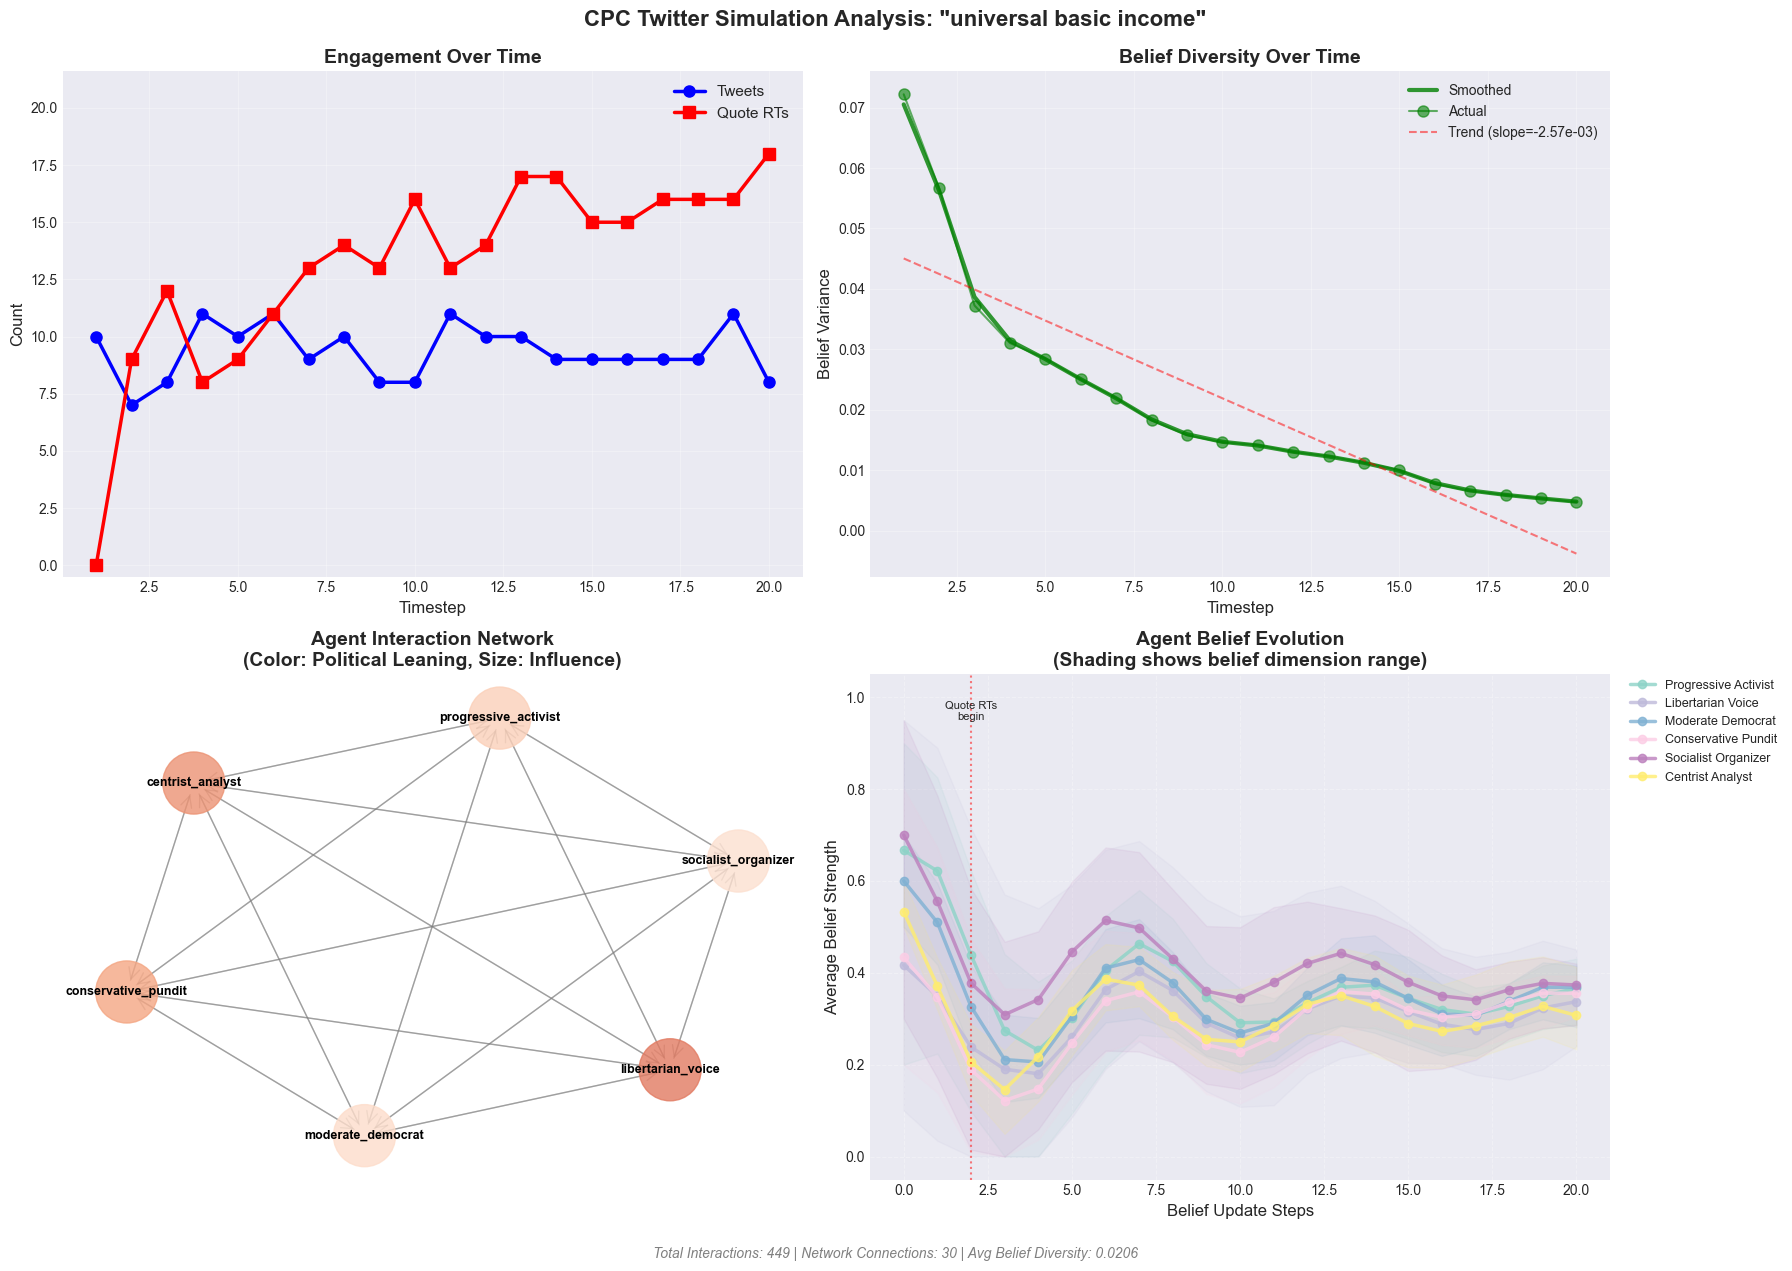


📊 Detailed Belief Evolution Analysis:

progressive_activist:
  Initial beliefs: [0.900, 0.200, 0.900]
  Final beliefs:   [0.381, 0.287, 0.431]
  Total change:    0.705
  Connections:     5 following, 5 followers

libertarian_voice:
  Initial beliefs: [0.100, 0.950, 0.200]
  Final beliefs:   [0.240, 0.450, 0.321]
  Total change:    0.533
  Connections:     5 following, 5 followers

moderate_democrat:
  Initial beliefs: [0.700, 0.500, 0.600]
  Final beliefs:   [0.407, 0.282, 0.416]
  Total change:    0.409
  Connections:     5 following, 5 followers

conservative_pundit:
  Initial beliefs: [0.200, 0.800, 0.300]
  Final beliefs:   [0.304, 0.393, 0.369]
  Total change:    0.425
  Connections:     5 following, 5 followers

socialist_organizer:
  Initial beliefs: [0.850, 0.300, 0.950]
  Final beliefs:   [0.420, 0.286, 0.415]
  Total change:    0.687
  Connections:     5 following, 5 followers

centrist_analyst:
  Initial beliefs: [0.500, 0.600, 0.500]
  Final beliefs:   [0.276, 0.412, 0.233

In [9]:
# Enhanced Visualization with all fixes applied
# Replace the content of Cell [8] with this code

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Engagement Over Time (with annotations)
ax = axes[0, 0]
timesteps = range(1, len(simulation.metrics['tweets']) + 1)

# Plot lines
tweet_line = ax.plot(timesteps, simulation.metrics['tweets'], 'b-o', 
                     label='Tweets', linewidth=2.5, markersize=8)[0]
qrt_line = ax.plot(timesteps, simulation.metrics['quote_rts'], 'r-s', 
                   label='Quote RTs', linewidth=2.5, markersize=8)[0]
'''
# Add annotation for constant tweets
ax.annotate('6 agents × 1 tweet each', 
            xy=(len(timesteps)//2, 6), 
            xytext=(len(timesteps)//2, 7.5),
            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.5),
            fontsize=10, ha='center', color='blue')
'''
# Styling
ax.set_xlabel('Timestep', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Engagement Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, max(15, max(simulation.metrics['quote_rts'])*1.2))

# 2. Belief Variance Over Time (with enhanced visualization)
ax = axes[0, 1]
variance_data = simulation.metrics['belief_variance']

# Calculate rolling average for smoother line
if len(variance_data) > 3:
    from scipy.ndimage import gaussian_filter1d
    smoothed_variance = gaussian_filter1d(variance_data, sigma=0.5)
    ax.plot(timesteps, smoothed_variance, 'g-', linewidth=3, 
            label='Smoothed', alpha=0.8)

# Plot actual data points
ax.plot(timesteps, variance_data, 'go-', linewidth=1.5, 
        markersize=8, label='Actual', alpha=0.6)

# Add trend line
if len(variance_data) > 1:
    z = np.polyfit(timesteps, variance_data, 1)
    p = np.poly1d(z)
    ax.plot(timesteps, p(timesteps), "r--", alpha=0.5, 
            label=f'Trend (slope={z[0]:.2e})')

# Styling
ax.set_xlabel('Timestep', fontsize=12)
ax.set_ylabel('Belief Variance', fontsize=12)
ax.set_title('Belief Diversity Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Dynamic y-limits
v_min, v_max = min(variance_data), max(variance_data)
v_range = v_max - v_min
if v_range < 0.001:
    ax.set_ylim(v_min - 0.0005, v_max + 0.0005)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 3. Network visualization with metrics
ax = axes[1, 0]

# Calculate network metrics
in_degrees = dict(simulation.network.in_degree())
out_degrees = dict(simulation.network.out_degree())

# Node colors based on political leaning
node_colors = []
for node in simulation.network.nodes():
    agent = next((a for a in simulation.agents if a.agent_id == node), None)
    if agent:
        # Color based on beliefs: red (conservative) to blue (progressive)
        color_val = agent.beliefs[0]  # Government intervention belief
        node_colors.append(plt.cm.RdBu(color_val))

# Node sizes based on influence (in-degree)
node_sizes = [500 + in_degrees.get(node, 0) * 300 for node in simulation.network.nodes()]

# Layout
pos = nx.spring_layout(simulation.network, k=3, iterations=100, seed=42)

# Draw network
nx.draw_networkx_nodes(simulation.network, pos, ax=ax,
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.8)

nx.draw_networkx_labels(simulation.network, pos, ax=ax,
                       font_size=9,
                       font_weight='bold')

nx.draw_networkx_edges(simulation.network, pos, ax=ax,
                      edge_color='gray',
                      arrows=True,
                      arrowsize=20,
                      alpha=0.5,
                      arrowstyle='->')

ax.set_title('Agent Interaction Network\n(Color: Political Leaning, Size: Influence)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

# 4. FIXED Agent Belief Evolution
ax = axes[1, 1]

# Create subplots for each belief dimension
belief_labels = ['Gov. Intervention', 'Individual Freedom', 'Economic Equality']
colors = plt.cm.Set3(np.linspace(0, 1, len(simulation.agents)))

# Check if we have belief history
has_history = any(len(agent.belief_history) > 1 for agent in simulation.agents)

if has_history:
    for i, agent in enumerate(simulation.agents):
        beliefs_array = np.array(agent.belief_history)
        
        if len(beliefs_array) > 1:
            # Calculate timesteps (0-indexed)
            time_points = np.arange(len(beliefs_array))
            
            # Plot average belief
            avg_beliefs = np.mean(beliefs_array, axis=1)
            
            # Main line
            ax.plot(time_points, avg_beliefs, 
                   color=colors[i],
                   linewidth=2.5,
                   marker='o',
                   markersize=6,
                   label=agent.agent_id.replace('_', ' ').title(),
                   alpha=0.8)
            
            # Add shaded area showing belief range
            if len(beliefs_array[0]) == 3:
                min_beliefs = np.min(beliefs_array, axis=1)
                max_beliefs = np.max(beliefs_array, axis=1)
                ax.fill_between(time_points, min_beliefs, max_beliefs, 
                              color=colors[i], alpha=0.1)

    # Styling
    ax.set_xlabel('Belief Update Steps', fontsize=12)
    ax.set_ylabel('Average Belief Strength', fontsize=12)
    ax.set_title('Agent Belief Evolution\n(Shading shows belief dimension range)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(-0.05, 1.05)
    
    # Legend outside plot
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
             borderaxespad=0, fontsize=9, framealpha=0.9)
    
    # Add vertical lines for major events
    if len(simulation.all_quote_rts) > 0:
        first_qrt_time = 2  # Quote RTs start from timestep 2
        ax.axvline(x=first_qrt_time, color='red', linestyle=':', 
                  alpha=0.5, label='First Quote RTs')
        ax.text(first_qrt_time, 0.95, 'Quote RTs\nbegin', 
               rotation=0, ha='center', fontsize=8)

else:
    # No belief evolution data
    ax.text(0.5, 0.5, 
           'No belief evolution detected.\n\n' +
           'Possible reasons:\n' +
           '• Simulation too short (run more timesteps)\n' +
           '• Belief updates too small\n' +
           '• Agents not interacting enough\n\n' +
           'Try running the enhanced simulation patch\n' +
           'and re-running with more timesteps.',
           ha='center', va='center', 
           transform=ax.transAxes,
           fontsize=11,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Belief Update Steps', fontsize=12)
    ax.set_ylabel('Average Belief Strength', fontsize=12)
    ax.set_title('Agent Belief Evolution', fontsize=14, fontweight='bold')

# Overall figure adjustments
plt.tight_layout()
fig.suptitle(f'CPC Twitter Simulation Analysis: "{simulation.topic}"', 
            fontsize=16, fontweight='bold', y=1.02)

# Add summary statistics
total_interactions = len(simulation.all_tweets) + len(simulation.all_quote_rts)
network_edges = len(simulation.network.edges())
avg_final_variance = np.mean(simulation.metrics['belief_variance'])

summary_text = (f"Total Interactions: {total_interactions} | "
               f"Network Connections: {network_edges} | "
               f"Avg Belief Diversity: {avg_final_variance:.4f}")
fig.text(0.5, -0.02, summary_text, ha='center', fontsize=10, 
         style='italic', color='gray')

plt.show()

# Additional detailed analysis
print("\n📊 Detailed Belief Evolution Analysis:")
print("="*60)
for agent in simulation.agents:
    beliefs_array = np.array(agent.belief_history)
    if len(beliefs_array) > 1:
        initial = beliefs_array[0]
        final = beliefs_array[-1]
        total_change = np.linalg.norm(final - initial)
        
        print(f"\n{agent.agent_id}:")
        print(f"  Initial beliefs: [{initial[0]:.3f}, {initial[1]:.3f}, {initial[2]:.3f}]")
        print(f"  Final beliefs:   [{final[0]:.3f}, {final[1]:.3f}, {final[2]:.3f}]")
        print(f"  Total change:    {total_change:.3f}")
        print(f"  Connections:     {len(agent.following)} following, {len(agent.followers)} followers")

## 9. Quote RT Analysis

In [10]:
# Analyze quote RT patterns
if quote_rts:
    print("\n📊 Quote Retweet Analysis:")
    print("=" * 60)
    
    # Group by alignment
    alignments = [qrt['alignment'] for qrt in quote_rts]
    positive_qrts = sum(1 for a in alignments if a > 0.3)
    negative_qrts = sum(1 for a in alignments if a < -0.3)
    neutral_qrts = len(alignments) - positive_qrts - negative_qrts
    
    print(f"\n🤝 Positive Quote RTs (agreement): {positive_qrts} ({positive_qrts/len(quote_rts)*100:.1f}%)")
    print(f"⚔️  Negative Quote RTs (disagreement): {negative_qrts} ({negative_qrts/len(quote_rts)*100:.1f}%)")
    print(f"🤔 Neutral Quote RTs: {neutral_qrts} ({neutral_qrts/len(quote_rts)*100:.1f}%)")
    
    # Most active quote retweeters
    qrt_counts = {}
    for qrt in quote_rts:
        qrt_counts[qrt['author']] = qrt_counts.get(qrt['author'], 0) + 1
    
    print("\n🏆 Most Active Quote Retweeters:")
    for agent_id, count in sorted(qrt_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  • {agent_id}: {count} quote RTs")
    
    # Sample quote RTs
    print("\n💬 Sample Quote Retweets:")
    for qrt in quote_rts[:5]:
        original = next((t for t in tweets if t['id'] == qrt['quoted_tweet']), None)
        if original:
            print(f"\n  Original (@{qrt['original_author']}): \"{original['content'][:80]}...\"")
            print(f"  Quote RT (@{qrt['author']}, align={qrt['alignment']:.2f}): \"{qrt['content'][:80]}...\"")
else:
    print("\n⚠️ No quote retweets generated. Try running more timesteps or adjusting parameters.")


📊 Quote Retweet Analysis:

🤝 Positive Quote RTs (agreement): 258 (98.5%)
⚔️  Negative Quote RTs (disagreement): 0 (0.0%)
🤔 Neutral Quote RTs: 4 (1.5%)

🏆 Most Active Quote Retweeters:
  • progressive_activist: 48 quote RTs
  • moderate_democrat: 45 quote RTs
  • socialist_organizer: 45 quote RTs
  • conservative_pundit: 43 quote RTs
  • libertarian_voice: 41 quote RTs
  • centrist_analyst: 40 quote RTs

💬 Sample Quote Retweets:

  Original (@centrist_analyst): "Universal Basic Income is an intriguing concept with potential to address econom..."
  Quote RT (@progressive_activist, align=0.86): ""Absolutely! Universal Basic Income has immense potential to tackle economic dis..."

  Original (@centrist_analyst): "Excited to dive into the ongoing debate on #UniversalBasicIncome! As a centrist ..."
  Quote RT (@progressive_activist, align=0.86): "Absolutely! Evidence-based policy-making is crucial for progress. I appreciate t..."

  Original (@centrist_analyst): "As a centrist policy wonk, 

## 10. Export Results

In [11]:
# Export simulation data
simulation_data = {
    'metadata': {
        'topic': simulation.topic,
        'num_agents': len(agents),
        'timesteps': len(simulation.metrics['tweets']),
        'timestamp': datetime.now().isoformat()
    },
    'agents': [
        {
            'id': agent.agent_id,
            'personality': agent.personality,
            'initial_beliefs': agent.belief_history[0].tolist(),
            'final_beliefs': agent.beliefs.tolist(),
            'num_tweets': len(agent.tweet_history),
            'num_quote_rts': len(agent.quote_rt_history)
        }
        for agent in agents
    ],
    'metrics': simulation.metrics,
    'network': {
        'nodes': list(simulation.network.nodes()),
        'edges': list(simulation.network.edges()),
        'density': nx.density(simulation.network)
    }
}

# Save to file
filename = f"cpc_simulation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, 'w') as f:
    json.dump(simulation_data, f, indent=2)

print(f"\n💾 Simulation data saved to: {filename}")
print(f"\n✅ CPC Twitter Simulation Complete!")


💾 Simulation data saved to: cpc_simulation_20250529_184404.json

✅ CPC Twitter Simulation Complete!
